In [177]:
import emcee 
import numpy as np
from matplotlib import pyplot as plt
import random as rd
from scipy.stats import uniform
import corner


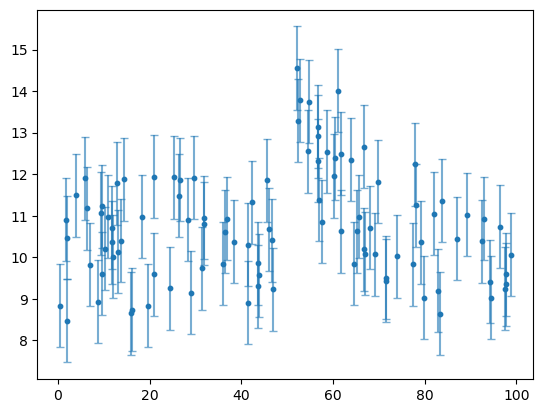

In [178]:

data = np.load('transient.npy', allow_pickle=True)
time = data[:,0]
flux = data[:,1]
sigma = data[:,2]
fig5, ax5 = plt.subplots()
ax5.errorbar(time, flux, yerr=sigma, fmt='None', markersize=2.8, alpha = 0.6, capsize= 3, zorder = 2)
ax5.scatter(time, flux, s=10, zorder = 3)

c:\Users\nicco\anaconda3\Lib\site-packages\emcee\moves\red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Acceptance rates: [0.5487 0.5439 0.5414 0.5544 0.5367 0.5277 0.5439 0.5437 0.5412 0.5542]


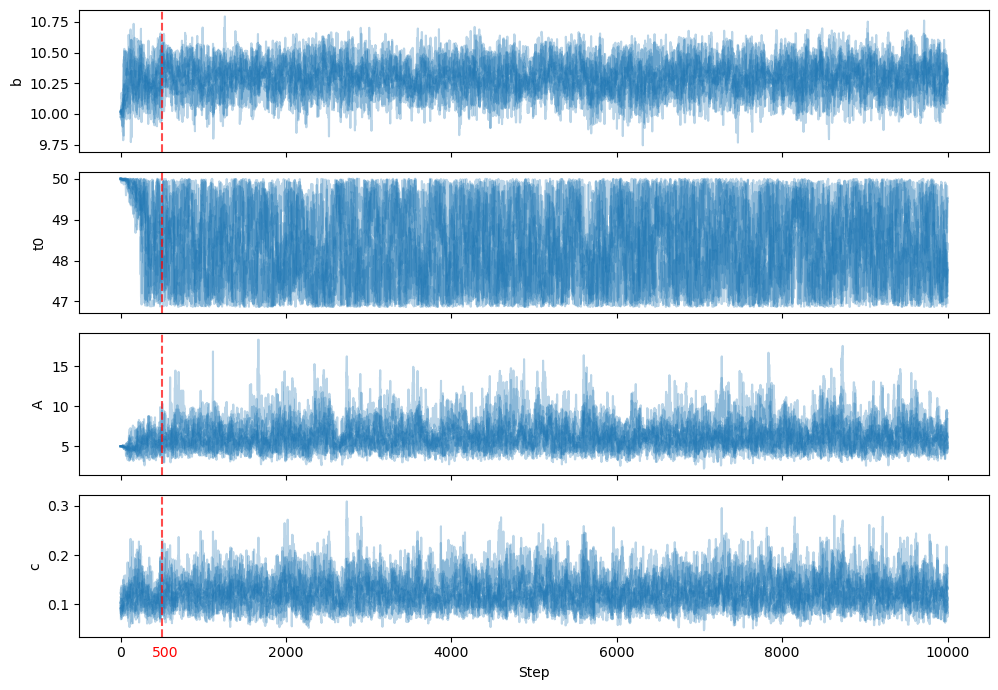

In [179]:

def model(params, t):
    b, t0, A, c = params
    exponent = -c*(t - t0)
    exponent = np.clip(exponent, -100, 100)  # Prevent overflow
    f = A * np.exp(exponent)  # (T,)
    return np.where(t < t0, b, b + f) 


def LogLikelihood (params, t, y, sigmay):
    flux_model = model(params, time)
    return -0.5*np.sum(((y-flux_model)/sigmay)**2)

def LogPrior (params):
    b, t0, A, c = params
    '''if 0<=b<= 50 and 0<=t0<=50 and 0<=A<=100 and -5<=lnc<=5:
        return 0.0
    return -np.inf'''
    if (0 <= b <= 50 and 0 <= t0 <= 50 and 0 <= A <= 100 and np.e**-5<=c<=np.e**5):
        return -np.log(c)  # c_prior where lnc_prior is uniform (-5,5)
    else:
        return -np.inf 

def LogPosterior (params, t, y ,sigmay):
    lp = LogPrior(params)
    if np.isfinite(lp):
        return LogLikelihood(params, t, y, sigmay) + lp
    else: 
        return -np.inf
    

ndim = 4
nwalkers = 10
burn = 500
nsteps = 10000
np.random.seed(0)

starting_guesses = np.array([10,50, 5,1e-1]) + 1e-2*np.random.randn(nwalkers, ndim)

sampler = emcee.EnsembleSampler(nwalkers, ndim, LogPosterior, args=[time, flux, sigma])
sampler.run_mcmc(starting_guesses, nsteps)
acceptance_rates = sampler.acceptance_fraction
print("Acceptance rates:", acceptance_rates)
emcee_trace  = sampler.get_chain()

fig1, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
labels = ["b", "t0", "A", "c"]
steps = np.arange(nsteps)
for i in range(ndim):
    axes[i].plot(steps, emcee_trace[:,:, i], alpha=0.3, color = '#1f77b4')
    axes[i].axvline(x=burn, color='red', linestyle='--', alpha=0.7)
    if i == ndim - 1:
        axes[i].annotate(f'{burn}', 
                         xy=(burn, axes[i].get_ylim()[0]),     # x pos, bottom of y-axis
                         xytext=(-7,-7), 
                         textcoords='offset points',
                         ha='left', va='top',
                         fontsize=10, color='red',
        )
    axes[i].set_ylabel(labels[i])
axes[-1].set_xlabel("Step")
plt.tight_layout()



Autocorrelation times for the 4 parameters: [73.68513736 86.29339567 80.96029738 75.27865762]
Traces after burn-in and thinning


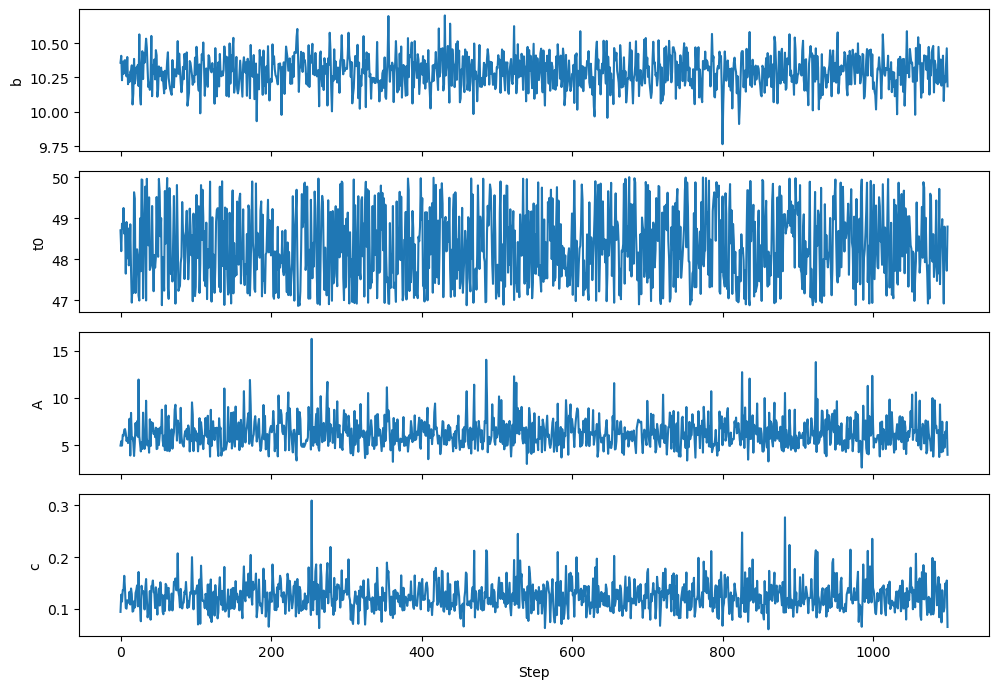

In [180]:
#autocorrelation time
tau = sampler.get_autocorr_time(tol = 0)
print("Autocorrelation times for the 4 parameters:", tau)
thin = int(np.max(tau))
emcee_trace = sampler.get_chain(discard=burn, thin=thin, flat=True).reshape(-1, ndim)

print("Traces after burn-in and thinning")
fig2, axes2 = plt.subplots(ndim, figsize=(10, 7), sharex=True)
for i in range(ndim):
    axes2[i].plot(emcee_trace[:, i])
    axes2[i].set_ylabel(labels[i])
axes2[-1].set_xlabel("Step")
plt.tight_layout()
plt.show()

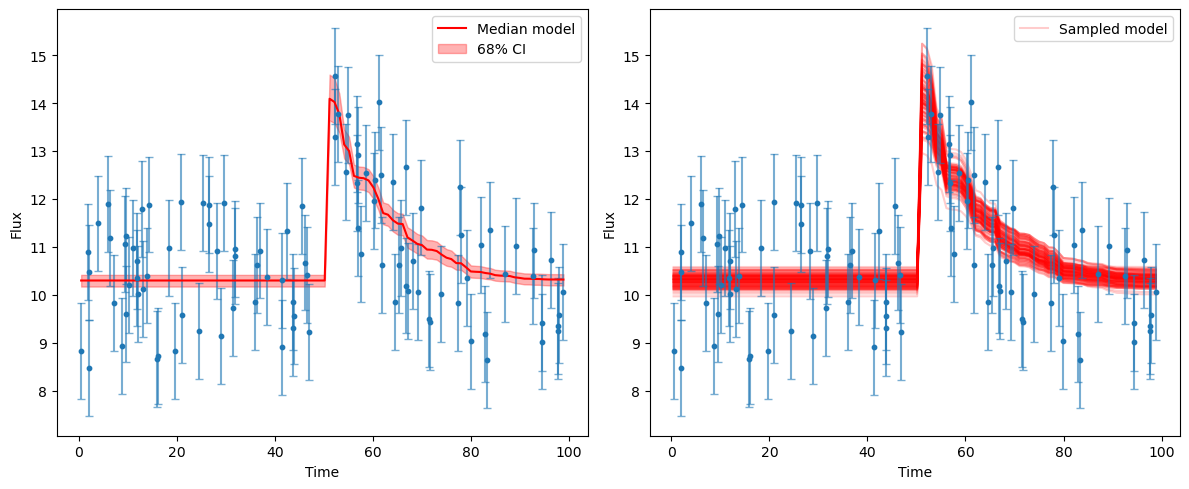

In [181]:
fig3, ax3 = plt.subplots(1, 2, figsize=(12,5))
ax3[0].errorbar(time, flux, yerr=sigma, fmt='None', markersize=2.8, alpha = 0.6, capsize= 3, zorder =2)
ax3[0].scatter(time, flux, s=10, zorder = 3)
time_interval = np.linspace(np.min(time), np.max(time), len(time))
preds = np.array([model(params, time) for params in emcee_trace])
median = np.median(preds, axis=0)
lower = np.percentile(preds, 16, axis=0)
upper = np.percentile(preds, 84, axis=0)
ax3[0].plot(time_interval, median, color='red', label='Median model', zorder = 2)
ax3[0].fill_between(time_interval, lower, upper, color='red', alpha=0.3, label='68% CI', zorder = 1)
ax3[0].set_xlabel("Time")
ax3[0].set_ylabel("Flux")
ax3[0].legend()

flat_trace = emcee_trace.reshape(-1, emcee_trace.shape[-1])  # shape: (n_samples, n_params)
sampled_params = flat_trace[np.random.choice(flat_trace.shape[0], size=100, replace=False)]
ax3[1].errorbar(time, flux, yerr=sigma, fmt='None', markersize=2.8, alpha = 0.6, capsize= 3, zorder = 2)
ax3[1].scatter(time, flux, s=10, zorder=3)
subsample = np.array([model(params, time) for params in sampled_params])
for i in range(100):
    ax3[1].plot(time_interval, subsample[i], color='red', alpha=0.2, zorder = 1, label='Sampled model' if i == 0 else "")
ax3[1].set_xlabel("Time")
ax3[1].set_ylabel("Flux")
ax3[1].legend()
plt.tight_layout()


Posterior distributions


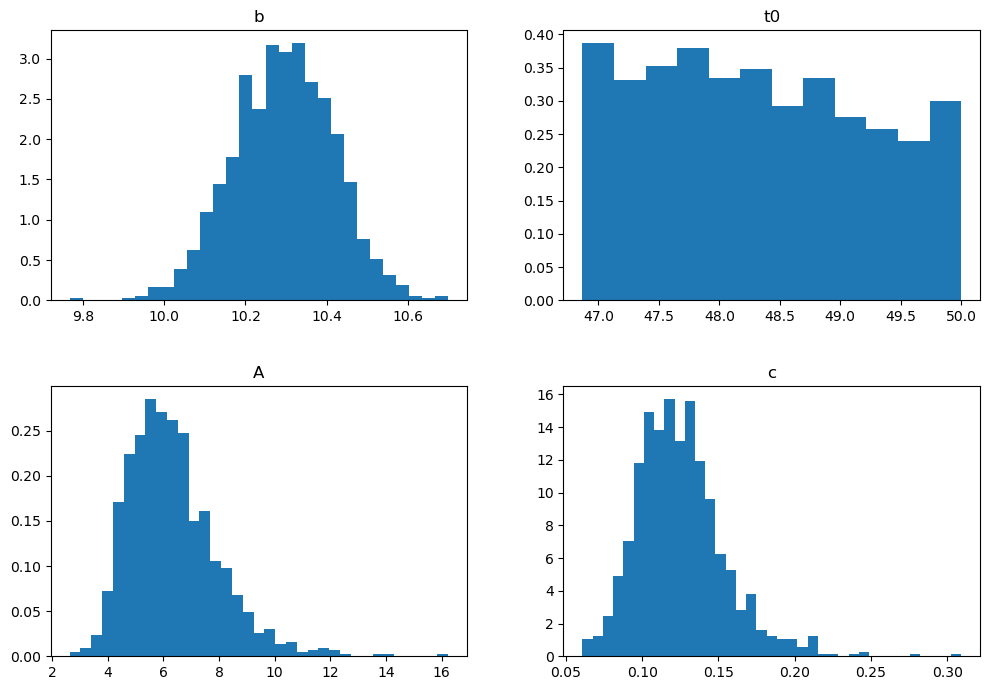

In [182]:

print("Posterior distributions")
fig4, axes4 = plt.subplots(2, 2, figsize=(10, 7))

for i in range(2):
    for j in range(2):
        axes4[i][j].hist(emcee_trace[:, 2*i+j], density = True, bins = 'auto')
        axes4[i][j].set_title(labels[2*i+j])
plt.tight_layout(h_pad=3.0, w_pad=4.0)
plt.show()

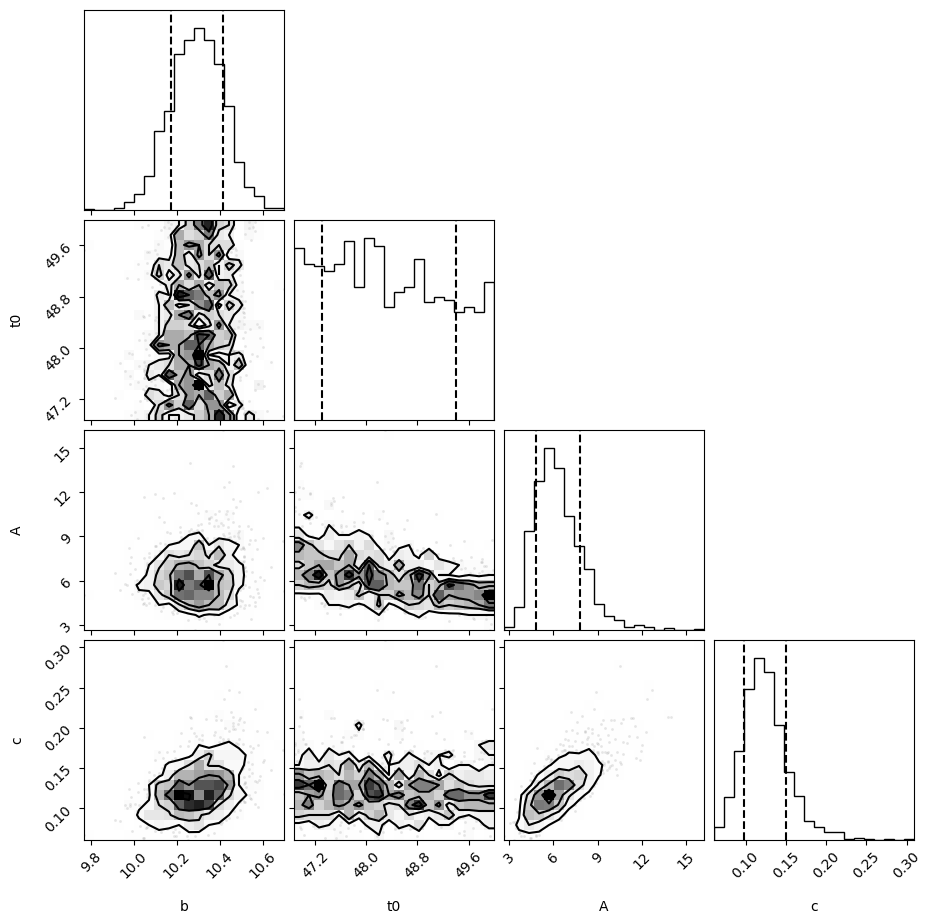

In [183]:
fig = corner.corner(flat_trace, labels=labels, quantiles=(0.16, 0.84))